In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
reviews= pd.read_csv("reviews.csv")

In [4]:
"""Cleaning Data"""

def correction_price (x):
    """
    Make the price column to floats
    """
    if type(x) ==str:
        
        x=x.replace(",","")
        
        x=x.replace("$","")
        
        x=x.replace("%", "")
        
        x=float(x)    
    return (x)

def correction_zipcode (x):
    """
    Clean Zipcode '99\n98122'into '98122' """
    
    if x == '99\n98122':
        x='98122'
        
    return x

def get_year(x):
    if type(x) != float:
        x= x.split("-")[0]
    
    return 2016-float(x)

def streamline_num_reviews(x):
    if x<10:
        x=str("0-10")
    elif x<=25:
        x=str("10-25")
    elif x<=50:
        x=str("25-50")
    elif x<=75:
        x=str("50-75")
    elif x<=100:
        x=str("75-100")
    elif x<=150:
        x=str("100-150")
    else:
        x=str(">150")
    
    return x
def streamline_num_reviews1(x):
    if x<10:
        x=str("0-10")
    elif x<=20:
        x=str("10-20")
    elif x<=30:
        x=str("20-30")
    elif x<=40:
        x=str("30-40")
    elif x<=50:
        x=str("40-50")
    
    else:
        x=str(">50")
    
    return x


fill_mean = lambda col: col.fillna(col.mean())

t_F_handling = lambda x: 1 if x=="t" else 0

In [5]:
#Creating column that contents the year and the month
calendar["date_year_month"]=calendar["date"].apply(lambda x: x[:-3])

#Create a column that contents 1 if a listing was available  and 0 if not
calendar["available_binary"] = calendar["available"].apply(t_F_handling)

#Cleaning the Zipcode column
listings["zipcode"]= listings["zipcode"].apply(lambda x: correction_zipcode(x))

In [6]:
#Join price, zipcode & neighborhood column to the calendar DataFrame
calendar= pd.merge(left=calendar, right=listings[["id", "price","zipcode", "neighbourhood_group_cleansed"]], left_on="listing_id", right_on="id", how="left")

#Fill the missing values for the price column in the Calendar DataFrame withthe prices from the listings DataFrame
calendar["price_x"] = calendar["price_x"].fillna(calendar["price_y"])

#Clean the price column
calendar["price_x"]= calendar["price_x"].apply(lambda x: correction_price(x))
calendar.head()



,listing_id,date,available,price_x,date_year_month,available_binary,id,price_y,zipcode,neighbourhood_group_cleansed
0,241032,2016-01-04,t,85.0,2016-01,1,241032,$85.00,98119,Queen Anne
1,241032,2016-01-05,t,85.0,2016-01,1,241032,$85.00,98119,Queen Anne
2,241032,2016-01-06,f,85.0,2016-01,0,241032,$85.00,98119,Queen Anne
3,241032,2016-01-07,f,85.0,2016-01,0,241032,$85.00,98119,Queen Anne
4,241032,2016-01-08,f,85.0,2016-01,0,241032,$85.00,98119,Queen Anne


In [7]:
# Average price of all listings per month
season= calendar[["price_x", "date_year_month"]].groupby(by="date_year_month").mean().reset_index()

#Average price of listings per month and zipcode
season_zipcode = calendar[["price_x", "date_year_month", "zipcode"]].groupby(by=["zipcode","date_year_month"]).mean().reset_index()

#Average price per month and neighborhood
season_neighborhood = calendar[["price_x", "date_year_month", "neighbourhood_group_cleansed"]].groupby(by=["neighbourhood_group_cleansed","date_year_month"]).mean().reset_index()

#Average price per zipcode
average_price_zipcode = calendar[["price_x", "zipcode"]].groupby(by=["zipcode"]).mean().reset_index()

#Average price per neighborhood
average_price_neighborhood = calendar[["price_x", "neighbourhood_group_cleansed"]].groupby(by=["neighbourhood_group_cleansed"]).mean().reset_index()

#Average price of all listings over timespan of the data
average_price_overall = listings["price"].apply(lambda x: correction_price(x)).mean()


In [8]:
average_price_neighborhood.sort_values(by="price_x")

,neighbourhood_group_cleansed,price_x
5,Delridge,88.047997
10,Northgate,92.166712
8,Lake City,94.825843
13,Rainier Valley,95.748876
1,Beacon Hill,97.183237
15,University District,99.233550
14,Seward Park,109.277771
7,Interbay,115.956912
11,Other neighborhoods,126.192516
0,Ballard,127.077844


# In which months are the prices of Airbnb appartments in seattle the most expensive?

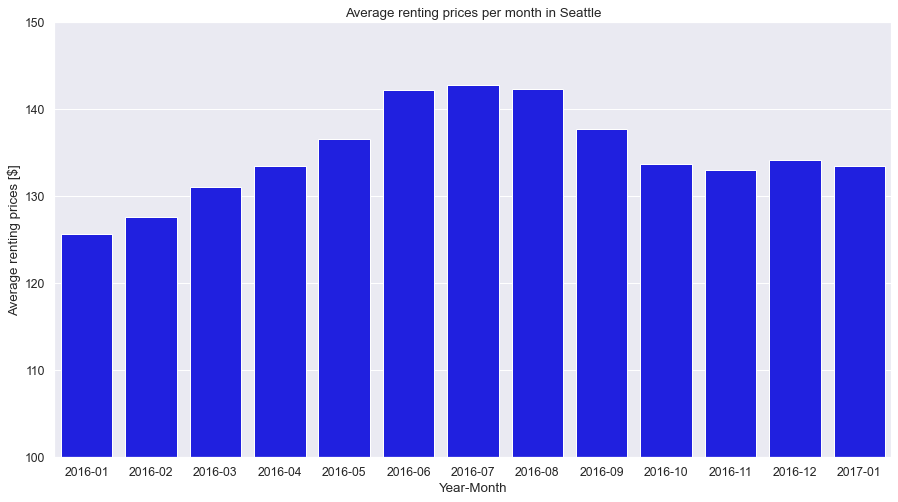

In [72]:
#Plot The average renting prices per month in Seatlle 
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.11)
plot= sns.barplot(x=season["date_year_month"], y=season["price_x"], color="blue")
plot.set(ylim=(100,150), title="Average renting prices per month in Seattle", xlabel="Year-Month", ylabel="Average renting prices [$]");




FINDING: Prices seem to spike in the summer months of june, july and august

In [10]:
zipcode_max_price_month = season_zipcode[season_zipcode["date_year_month"].isin(["2016-06", "2016-07", "2016-08"])][["zipcode", "price_x"]].groupby(by="zipcode").max().reset_index()
zipcode_max_price_month= pd.merge(left=zipcode_max_price_month,right=season_zipcode, how="left", on=["zipcode", "price_x"])

neighborhood_max_price_month = season_neighborhood[season_neighborhood["date_year_month"].isin(["2016-06", "2016-07", "2016-08"])][["neighbourhood_group_cleansed", "price_x"]].groupby(by="neighbourhood_group_cleansed").max().reset_index()
neighborhood_max_price_month= pd.merge(left=neighborhood_max_price_month,right=season_neighborhood, how="left", on=["neighbourhood_group_cleansed", "price_x"])

In [11]:
#Average price of listings i zipcode in summer months (06,07,08)
zipcode_mean_price_month = season_zipcode[season_zipcode["date_year_month"].isin(["2016-06", "2016-07", "2016-08"])][["zipcode", "price_x"]].groupby(by="zipcode").mean().reset_index()
#zipcode_mean_price_month
#zipcode_mean_price_month= pd.merge(left=zipcode_mean_price_month,right=season_zipcode, how="left", on=["zipcode", "price_x"])

neighborhood_mean_price_month = season_neighborhood[season_neighborhood["date_year_month"].isin(["2016-06", "2016-07", "2016-08"])][["neighbourhood_group_cleansed", "price_x"]].groupby(by="neighbourhood_group_cleansed").mean().reset_index().sort_values(by="price_x", ascending=False)
#neighborhood_mean_price_month= pd.merge(left=neighborhood_mean_price_month,right=season_neighborhood, how="left", on=["neighbourhood_group_cleansed", "price_x"])
neighborhood_mean_price_month

,neighbourhood_group_cleansed,price_x
6,Downtown,198.464708
9,Magnolia,194.859246
12,Queen Anne,171.236336
16,West Seattle,153.797669
3,Cascade,146.488563
2,Capitol Hill,138.993815
4,Central Area,137.134093
0,Ballard,132.946597
11,Other neighborhoods,131.417925
7,Interbay,120.059694


In [45]:
zipcode_max_avg_price_month= pd.merge(left=zipcode_max_price_month, right=average_price_zipcode, how="left", on="zipcode")
zipcode_max_avg_price_month["effect"] = zipcode_max_avg_price_month["price_x_x"]/zipcode_max_avg_price_month["price_x_y"]

#Comparison between Average price over summer months and average price of the zipcode/neighborhood over the whole timespan
zipcode_mean_avg_price_month= pd.merge(left=zipcode_mean_price_month, right=average_price_zipcode, how="left", on="zipcode")
zipcode_mean_avg_price_month["effect"] = zipcode_mean_avg_price_month["price_x_x"]/zipcode_mean_avg_price_month["price_x_y"]

neighborhood_max_avg_price_month= pd.merge(left=neighborhood_max_price_month, right=average_price_neighborhood, how="left", on="neighbourhood_group_cleansed")
neighborhood_max_avg_price_month["effect"] = neighborhood_max_avg_price_month["price_x_x"]/neighborhood_max_avg_price_month["price_x_y"]

#Comparison between Average price over summer months and average price of the zipcode over the whole timespan
neighborhood_mean_avg_price_month= pd.merge(left=neighborhood_mean_price_month, right=average_price_neighborhood, how="left", on="neighbourhood_group_cleansed")
neighborhood_mean_avg_price_month["effect"] = neighborhood_mean_avg_price_month["price_x_x"]/neighborhood_mean_avg_price_month["price_x_y"]


# Which neighbourhood is most affected by the summer peak?

In [46]:
#Durchschnittlicher Preis vom ganzen Jahr veeglichen mit dem durchschnittlichen Preis aus den 3 Sommermonaten
neighborhood_mean_avg_price_month.sort_values(by="effect", ascending=False)

,neighbourhood_group_cleansed,price_x_x,price_x_y,effect
0,Downtown,198.464708,174.704714,1.136001
3,West Seattle,153.797669,146.522896,1.049649
7,Ballard,132.946597,127.077844,1.046182
8,Other neighborhoods,131.417925,126.192516,1.041408
15,Northgate,95.911622,92.166712,1.040632
14,Lake City,98.605526,94.825843,1.039859
2,Queen Anne,171.236336,164.708670,1.039632
13,Rainier Valley,99.513568,95.748876,1.039318
11,University District,102.770368,99.233550,1.035641
9,Interbay,120.059694,115.956912,1.035382


FINDING: Appartments in Downtown Seattle are 13,6% higher in price in the summer months of june, july and august compared to the average price over the whole year

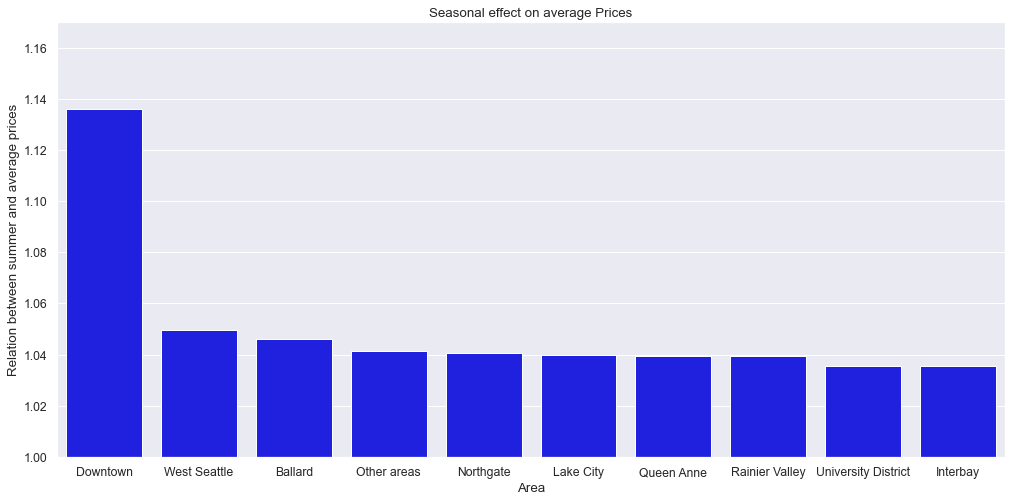

In [70]:
#Plot of the seasonal effect on prices in different areas
df=neighborhood_mean_avg_price_month.sort_values(by="effect", ascending=False)
df["neighbourhood_group_cleansed"] = df["neighbourhood_group_cleansed"].apply(lambda x: "Other areas" if x=="Other neighborhoods" else x)

x_plot =df["neighbourhood_group_cleansed"]
y_plot =df["effect"]

plt.figure(figsize=(17,8))
sns.set(font_scale = 1.11)
plot= sns.barplot(x=x_plot[:10], y=y_plot[:10], color="blue")
plot.set(ylim=(1,1.17), title="Seasonal effect on average Prices", xlabel="Area", ylabel="Relation between summer and average prices");


In [14]:
#Average prices per month in Downtown Seattle
Downtown = calendar[["date_year_month", "price_x", "neighbourhood_group_cleansed"]][calendar["neighbourhood_group_cleansed"] == "Downtown"].groupby(by=["date_year_month", "neighbourhood_group_cleansed"]).mean().reset_index()
Downtown

,date_year_month,neighbourhood_group_cleansed,price_x
0,2016-01,Downtown,149.787871
1,2016-02,Downtown,152.370982
2,2016-03,Downtown,165.450822
3,2016-04,Downtown,170.263648
4,2016-05,Downtown,179.068716
5,2016-06,Downtown,199.197044
6,2016-07,Downtown,199.046379
7,2016-08,Downtown,197.150700
8,2016-09,Downtown,178.845535
9,2016-10,Downtown,167.880706


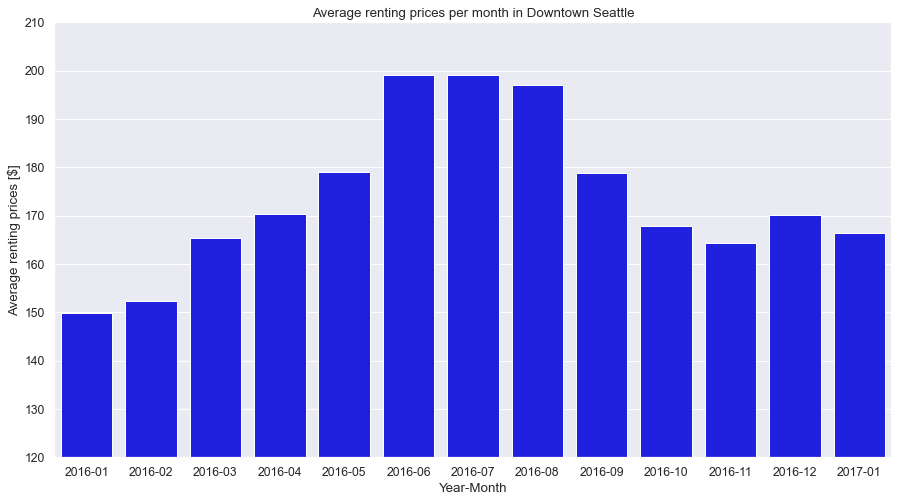

In [71]:
#Plot of average prices per month in Downtown Seattle
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.11)
plot= sns.barplot(x=Downtown["date_year_month"], y=Downtown["price_x"], color="blue")
plot.set(ylim=(120,210), title="Average renting prices per month in Downtown Seattle", xlabel="Year-Month", ylabel="Average renting prices [$]");


"Regression um Preis vorherzusagen
Was soll beschreibend sein:
"hostsince", "host_response_rate", "host_is_superhost", "host_listings_count", "host_has_profil_pic", "host_identity_verified", "neighbourhood_group_cleansed", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "bed_type", "number_of_reviews", "review_scores_rating", "instant_bookable", "cancellation_policy", "reviews_per_month""

In [16]:
#Columns to be included in the regression
columns= ["price","host_since_streamlined","host_response_rate", "host_is_superhost", "host_listings_count","host_identity_verified", "neighbourhood_group_cleansed",
          "property_type", "accommodates", "bathrooms","bedrooms","beds", "bed_type","number_of_reviews", "review_scores_rating", "instant_bookable","cancellation_policy", "reviews_per_month"]

In [17]:
#Run this code just once, else you will have columns with just zeros
#Turning t into 1 and f into 0 for True and False
listings["host_has_profile_pic"]=listings["host_has_profile_pic"].apply(t_F_handling)
listings["host_is_superhost"] = listings["host_is_superhost"].apply(t_F_handling)
listings["host_identity_verified"] = listings["host_identity_verified"].apply(t_F_handling)
listings["instant_bookable"] = listings["instant_bookable"].apply(t_F_handling)

#Correction of the price, turn strings into the correct floats
listings["price"] = listings["price"].apply(lambda x :correction_price(x))

#Same with the host response rate, that is saved as a string in the origin Dataframe
listings["host_response_rate"]= listings["host_response_rate"].apply(lambda x: correction_price(x))

#Fill NAN with Mean for numeric variables
listings[["host_response_rate"]] = listings[["host_response_rate"]].apply(fill_mean, axis=0)
listings[["bathrooms"]] = listings[["bathrooms"]].apply(fill_mean, axis=0)
listings[["bedrooms"]] = listings[["bedrooms"]].apply(fill_mean, axis=0)
listings[["beds"]] = listings[["beds"]].apply(fill_mean, axis=0)
listings[["review_scores_rating"]] = listings[["review_scores_rating"]].apply(fill_mean, axis=0)
listings[["reviews_per_month"]] = listings[["reviews_per_month"]].apply(fill_mean, axis=0)

#Make Years out of the date for the variable "host since"
listings["host_since_streamlined"] = listings["host_since"].apply(lambda x:get_year(x))

#drop na's from columns where just very few values in rows are missing 
listings.dropna(axis=0, subset=["host_since_streamlined", "host_listings_count", "host_has_profile_pic", "property_type"], inplace=True)

#'categorial variables' to be considered in the regression
cat_var = ["neighbourhood_group_cleansed", "property_type", "room_type", "bed_type","cancellation_policy"]

#cleaned dataset
listings[columns].head()

,price,host_since_streamlined,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_group_cleansed,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,85.0,5.0,96.000000,0,3.0,1,Queen Anne,Apartment,4,1.0,1.0,1.0,Real Bed,207,95.000000,0,moderate,4.070000
1,150.0,3.0,98.000000,1,6.0,1,Queen Anne,Apartment,4,1.0,1.0,1.0,Real Bed,43,96.000000,0,strict,1.480000
2,975.0,2.0,67.000000,0,2.0,1,Queen Anne,House,11,4.5,5.0,7.0,Real Bed,20,97.000000,0,strict,1.150000
3,100.0,3.0,94.886798,0,1.0,1,Queen Anne,Apartment,3,1.0,0.0,2.0,Real Bed,0,94.539262,0,flexible,2.078919
4,450.0,5.0,100.000000,0,2.0,1,Queen Anne,House,6,2.0,3.0,3.0,Real Bed,38,92.000000,0,strict,0.890000


In [18]:
def prepare_df(df, consider_na):
    
    """
    INPUT 
        list_cat_vars [list]: A list with the columns of the Dataframe, that are to be considered as categorial variables
        df [DataFrame]: The dataframe with the catecorial variables that are to be turned into dummies
        consider_na [bool]: Wheather or not Nan values should get an own column of dummies
    OUTPUT:
        The Dataframe df with the categorial columns turned into dummies
        """
    df= df.dropna(subset=["price"], axis=0)
    cat_vars = df.select_dtypes(include=["object"]).copy().columns
    
    for i in cat_vars:
        df = pd.concat([df.drop(labels=i, axis=1), pd.get_dummies(data=df[i], dummy_na=consider_na, prefix=i, prefix_sep="_", drop_first=True)],axis=1)
        
    return df

In [19]:
#pd.get_dummies(listings[cat_var])
listings["room_type"].head()

0    Entire home/apt
1    Entire home/apt
2    Entire home/apt
3    Entire home/apt
4    Entire home/apt
Name: room_type, dtype: object

# What attributes increase prices in Seattle the most?


In [20]:
clean_listings= prepare_df(df=listings[columns], consider_na=False)

#columns with more than .5% specifications, Dummy variables with less than 0.5% 1s not included in regression
columns_to_consider=clean_listings.columns[clean_listings.describe().loc["mean"] >0.005]
clean_listings= clean_listings[columns_to_consider]

In [21]:
#Define X and y
X=clean_listings.drop("price", axis=1)
y=clean_listings["price"]

In [22]:
# Split into train, test and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Create and fit
lm_model= LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
  
#Predict 
y_pred_test = lm_model.predict(X_test)
y_pred_train = lm_model.predict(X_train)

#Calculate r2 for train and test samples
r2_test = r2_score(y_test,y_pred_test)
r2_train = r2_score(y_train,y_pred_train)

In [23]:
r2_test

0.5475810682503601

In [24]:
r2_train

0.5440804864198202

In [25]:
Coeff= pd.DataFrame(data=lm_model.coef_, index=X_train.columns.to_list(), columns=["Coefficients"]).reset_index()
Coeff["Absolute"]=Coeff["Coefficients"].apply(lambda x: np.abs(x))

In [26]:
Coeff= Coeff.sort_values(by=['Coefficients'], ascending=False)
Coeff= Coeff.rename(columns={"index":"Variables"})
Coeff

,Variables,Coefficients,Absolute
18,neighbourhood_group_cleansed_Downtown,34.829551,34.829551
20,neighbourhood_group_cleansed_Magnolia,31.531152,31.531152
32,property_type_Loft,30.906852,30.906852
7,bedrooms,27.520637,27.520637
6,bathrooms,27.411965,27.411965
23,neighbourhood_group_cleansed_Queen Anne,26.508005,26.508005
15,neighbourhood_group_cleansed_Cascade,25.843812,25.843812
37,bed_type_Real Bed,25.804004,25.804004
29,property_type_Cabin,18.792226,18.792226
5,accommodates,15.506518,15.506518


In [27]:
Coeff.sort_values(by="Absolute", ascending=False)

,Variables,Coefficients,Absolute
18,neighbourhood_group_cleansed_Downtown,34.829551,34.829551
21,neighbourhood_group_cleansed_Northgate,-32.804185,32.804185
17,neighbourhood_group_cleansed_Delridge,-31.688218,31.688218
20,neighbourhood_group_cleansed_Magnolia,31.531152,31.531152
32,property_type_Loft,30.906852,30.906852
7,bedrooms,27.520637,27.520637
6,bathrooms,27.411965,27.411965
24,neighbourhood_group_cleansed_Rainier Valley,-27.141980,27.141980
23,neighbourhood_group_cleansed_Queen Anne,26.508005,26.508005
15,neighbourhood_group_cleansed_Cascade,25.843812,25.843812
